In [1]:
import sys
sys.path.append('.')
import matplotlib.pyplot as plt
from math import cos, sin
import numpy as np
from TrajectoryGenerator import TrajectoryGenerator
from mpl_toolkits.mplot3d import Axes3D
from Quadrotor import Quadrotor
from drone_3d_trajectory_following import *
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


In [ ]:

show_animation = False

# Simulation parameters
# change for adaptation
g = 9.81
m = 0.2
Ixx = 1
Iyy = 1
Izz = 1
T = 5

# Proportional coefficients
Kp_x = 1
Kp_y = 1
Kp_z = 1
Kp_roll = 25
Kp_pitch = 25
Kp_yaw = 25

# Derivative coefficients
Kd_x = 10
Kd_y = 10
Kd_z = 1


In [98]:
def quad_sim_trajectory_noise(x_c, y_c, z_c, T, pos=None, noise=None):
    """
    Calculates the necessary thrust and torques for the quadrotor to
    follow the trajectory described by the sets of coefficients
    x_c, y_c, and z_c.
    """
    if pos:
        x_pos = pos[0]
        y_pos = pos[1]
        z_pos = pos[2]
    else: 
        x_pos = 0
        y_pos = 0
        z_pos = 0
    
    x_vel = 0
    y_vel = 0
    z_vel = 0
    x_acc = 0
    y_acc = 0
    z_acc = 0
    roll = 0
    pitch = 0
    yaw = 0
    roll_vel = 0
    pitch_vel = 0
    yaw_vel = 0

    des_yaw = 0

    dt = 0.1
    t = 0

    q = Quadrotor(x=x_pos, y=y_pos, z=z_pos, roll=roll,
                  pitch=pitch, yaw=yaw, size=1, show_animation=False)

    i = 0
    n_run = 4
    irun = 0
    
    trajectory = []
    
    for i in range(len(x_c)):
        while t <= T:
            des_x_pos = calculate_position(x_c[i], t)
            des_y_pos = calculate_position(y_c[i], t)
            des_z_pos = calculate_position(z_c[i], t)
            des_x_vel = calculate_velocity(x_c[i], t)
            des_y_vel = calculate_velocity(y_c[i], t)
            des_z_vel = calculate_velocity(z_c[i], t)
            des_x_acc = calculate_acceleration(x_c[i], t)
            des_y_acc = calculate_acceleration(y_c[i], t)
            des_z_acc = calculate_acceleration(z_c[i], t)

            thrust = m * (g + des_z_acc + Kp_z * (des_z_pos -
                                                  z_pos) + Kd_z * (des_z_vel - z_vel))

            roll_torque = Kp_roll * \
                (((des_x_acc * sin(des_yaw) - des_y_acc * cos(des_yaw)) / g) - roll)
            pitch_torque = Kp_pitch * \
                (((des_x_acc * cos(des_yaw) - des_y_acc * sin(des_yaw)) / g) - pitch)
            yaw_torque = Kp_yaw * (des_yaw - yaw)
            
            #print(roll_torque,pitch_torque,yaw_torque)

            roll_vel += roll_torque * dt / Ixx
            pitch_vel += pitch_torque * dt / Iyy
            yaw_vel += yaw_torque * dt / Izz

            roll += roll_vel * dt
            pitch += pitch_vel * dt
            yaw += yaw_vel * dt

            R = rotation_matrix(roll, pitch, yaw)
            acc = (np.matmul(R, np.array(
                [0, 0, thrust.item()]).T) - np.array([0, 0, m * g]).T) / m
            x_acc = acc[0]
            y_acc = acc[1]
            z_acc = acc[2]
            x_vel += x_acc * dt
            y_vel += y_acc * dt
            z_vel += z_acc * dt
            
            if noise:
                w = lambda x: np.random.normal(0, x)
            else:
                w = lambda x: 0 
                
            x_pos += x_vel * dt + w(noise)
            y_pos += y_vel * dt + w(noise)
            z_pos += z_vel * dt + w(noise)

            q.update_pose(x_pos, y_pos, z_pos, roll, pitch, yaw)
            trajectory.append([x_pos, y_pos, z_pos, roll, pitch, yaw, x_vel, y_vel, z_vel])
            t += dt

        t = 0

    return trajectory, q


In [25]:

T =5 

waypoints = [[-5, -5, 5], [5, -5, 5], [5, 5, 5],[5, 5, 5]]

coef_len = len(waypoints)-1
x_coeffs = [[]]*coef_len
y_coeffs = [[]]*coef_len
z_coeffs = [[]]*coef_len

for i in range(len(waypoints)-1):
    traj = TrajectoryGenerator(waypoints[i], waypoints[(i + 1)], T)
    traj.solve()
    x_coeffs[i] = traj.x_c
    y_coeffs[i] = traj.y_c
    z_coeffs[i] = traj.z_c

    
traj, q = quad_sim_trajectory_noise(x_coeffs, y_coeffs, z_coeffs, T, pos=waypoints[0], noise=0.1)
traj = np.array(traj)


Done


/var/folders/h2/p2n4nzc90zb6lngs5bgtd6sc0000gn/T/ipykernel_18272/306449255.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traj = np.array(traj)


<IPython.core.display.Javascript object>


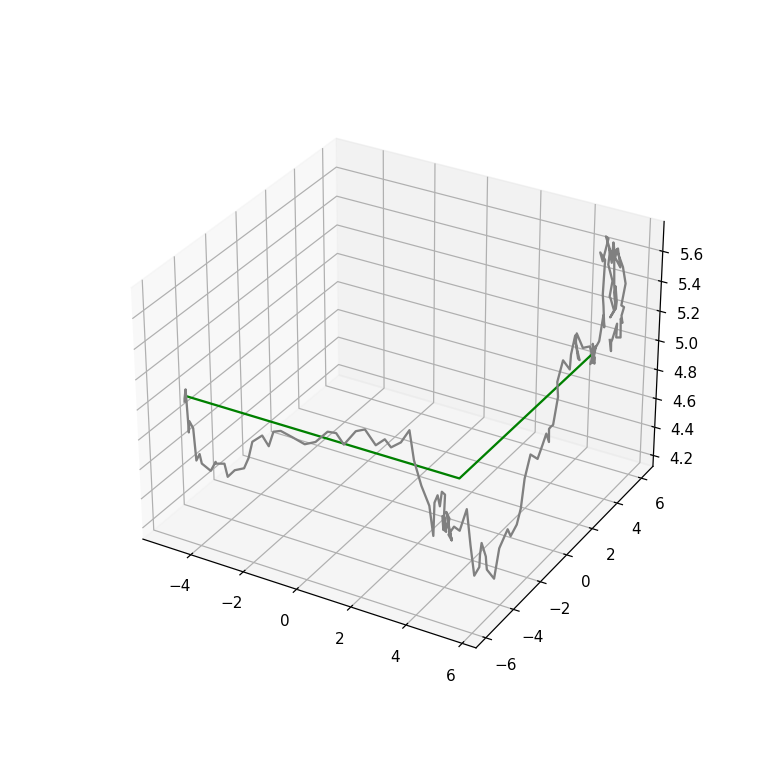

In [26]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

waypoints = np.array(waypoints)
ax.plot3D(waypoints[:,0], waypoints[:,1], waypoints[:,2], 'green')

ax.plot3D(traj[:,0], traj[:,1], traj[:,2], 'gray')


## Model

In [32]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

class MLP(nn.Module):
    
    def __init__(self, input_size=12 , embedding_size=32, output_size=3):
        super().__init__()
        
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_size, embedding_size),
          nn.ReLU(),
          nn.Linear(embedding_size, embedding_size),
          nn.ReLU(),
          nn.Linear(embedding_size, output_size)
        )

    def forward(self, x):
        '''Forward pass'''
        delta = self.layers(x)
        
        return delta #x[:3] + delta

## make dataset

In [ ]:
# data_dest = []
# data_coeffs = []

# for k in range(200):
#     waypoints = [np.array([0,0,0])]
    
#     for i in range(5):
#         # displacement
#         nextspot = np.random.rand(3)*2
#         waypoints.append(waypoints[-1]+nextspot)
        
#     T=5
#     for i in range(len(waypoints)-1):
#         traj = TrajectoryGenerator(waypoints[i], waypoints[(i + 1)], T)
#         traj.solve()
#         x_coeffs[i] = traj.x_c
#         y_coeffs[i] = traj.y_c
#         z_coeffs[i] = traj.z_c
        
#     #coefs = np.concatenate([x_coeffs, y_coeffs, z_coeffs])
#     data_coeffs.append([x_coeffs, y_coeffs, z_coeffs])
#     data_dest.append([sx, sy, sz])

In [100]:
data_dest = []
data_coefs = []
T=5

for k in range(200):
    # displacement
    sx, sy, sz = np.random.rand(3)*2
    
    waypoints = [[0,0,0], [sx, sy, sz]]

    traj = TrajectoryGenerator(waypoints[0], waypoints[(1)], T)
    traj.solve()
    x_coeffs = traj.x_c
    y_coeffs = traj.y_c
    z_coeffs = traj.z_c
    
    #coefs = np.concatenate([x_coeffs, y_coeffs, z_coeffs])
    data_coefs.append([x_coeffs, y_coeffs, z_coeffs])
    data_dest.append([sx, sy, sz])

In [106]:
np.concatenate(data_coefs[0]).shape

(18, 1)

In [108]:
targets = []

for i in range(200):
    #print(data_dest[i])
    d = data_coefs[i]
    traj, q = quad_sim_trajectory_noise([d[0]], [d[1]], [d[2]], T, pos=waypoints[0], noise=0.01)
    targets.append(traj[-1][:3])
    
    #print(traj[-1][:3])

In [128]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split


# create train and test indices
train, test = train_test_split(list(range(len(targets))), test_size=.3)

input_size = 13
hidden_layer_size = 300
learning_rate = 0.05
batch_size = 50
num_epochs = 100

class Data(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.Tensor(X)
        if not torch.is_tensor(y):
            self.y = torch.Tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = Data([np.concatenate(x).flatten() for x in data_coefs], targets)

batch_size=24

train_set = DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
test_set = DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [129]:
model = MLP(18,36,3)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 500

all_losses = []
for e in range(num_epochs):
    batch_losses = []
    for ix, (X, y) in enumerate(train_set):

        batch_losses = []

        #==========Forward pass===============

        preds = model(X)
        loss = loss_f(preds, y)

        #==========backward pass==============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        all_losses.append(loss.item())

    mbl = np.mean(np.sqrt(batch_losses)).round(3)

    if e % 50 == 0:
        print("Epoch [{}/{}], Batch loss: {}".format(e, num_epochs, mbl))


Epoch [0/500], Batch loss: 1.198
Epoch [50/500], Batch loss: 0.423
Epoch [100/500], Batch loss: 0.25
Epoch [150/500], Batch loss: 0.064
Epoch [200/500], Batch loss: 0.067
Epoch [250/500], Batch loss: 0.069
Epoch [300/500], Batch loss: 0.066
Epoch [350/500], Batch loss: 0.061
Epoch [400/500], Batch loss: 0.069
Epoch [450/500], Batch loss: 0.049


In [136]:
model.eval()

test_batch_losses = []
for X, y in test_set:
    test_preds = model(X)
    test_loss = loss_f(test_preds, y)

    test_batch_losses.append(test_loss.item())

print("Batch loss: {}".format(np.mean(test_batch_losses)))

Batch loss: 0.004309719428420067
